In [1]:
import h5py
import copy
import tqdm
import lmfit
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from rich.progress import Progress
from scipy.stats import binned_statistic
from utils.plot_utils import set_fontsize
from utils.hdf_utils import load_measurement_data_devices_attrs

In [2]:
hdf_dir = Path(".")

In [3]:
yag_channel = 0
pmt_channel = 1
pd_channel = 2
pdn_channel = 3

In [5]:
fname = "2021_3_3.hdf"

with h5py.File(hdf_dir / fname, 'r') as f:
    dset_names = list(f.keys())
dset_names

['1614800885 saturation scan R0 F1 53 mW',
 '1614810049 saturation scan 5x telescope R0 F1 FL & Q4 ABS 55.5 mW',
 '1614812595 saturation scan 5x telescope R0 F1 FL & Q4 ABS 55.5 mW tiled det max left',
 '1614814415 saturation scan 5x telescope R0 F1 FL & Q4 ABS 55.5 mW tiled det max right',
 '1614816196 saturation scan 5x telescope R0 F1 FL & Q4 ABS 55.5 mW tiled det max right straight back',
 '1614817455 saturation scan 5x telescope R0 F1 FL & Q4 ABS 55.5 mW tiled det max left straight back']

In [8]:
dset_names_saturation = [dname for dname in dset_names if 'saturation scan' in dname]
dset_names_saturation

['1614800885 saturation scan R0 F1 53 mW',
 '1614810049 saturation scan 5x telescope R0 F1 FL & Q4 ABS 55.5 mW',
 '1614812595 saturation scan 5x telescope R0 F1 FL & Q4 ABS 55.5 mW tiled det max left',
 '1614814415 saturation scan 5x telescope R0 F1 FL & Q4 ABS 55.5 mW tiled det max right',
 '1614816196 saturation scan 5x telescope R0 F1 FL & Q4 ABS 55.5 mW tiled det max right straight back',
 '1614817455 saturation scan 5x telescope R0 F1 FL & Q4 ABS 55.5 mW tiled det max left straight back']

In [9]:
slice_flm  = np.s_[100:250]
slice_absm = np.s_[-750:]
slice_fli  = np.s_[100:]
slice_absi = np.s_[10:]

yag_cutoff = 500
pdn_cutoff = 12000
abs_integral_cutoff = 1.5

scan_attr = 'Laser Lock 1 SetLockPointSeed2'

In [41]:
# something went wrong with the last 225 shots of run 2
mask_wrong = np.s_[:-250]

In [80]:
parameters = [0,1,2,3,4,5]
scan_data = dict([(p, []) for p in parameters])
scan_data_normalized = dict([(p, []) for p in parameters])

devices = ()
                
with Progress() as progress:
    task = progress.add_task("[green]Processing...", total = len(parameters))
    for par, dset_name in zip(parameters, dset_names_saturation):
        pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(fname, dset_name, devices)

        scan_parameters = np.array([pxie_attrs[idx][scan_attr] for idx in range(1,len(pxie)+1)])
        
        if par == 1:
            scan_parameters = np.asarray(scan_parameters[mask_wrong]).astype(float)
        
        bin_width = np.diff(np.unique(scan_parameters)).min()
        print(par, bin_width)
        bins = np.arange(scan_parameters.min()-bin_width/2, scan_parameters.max()+bin_width/2, bin_width)

        yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
        pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
        pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
        pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
        norm_data = -pd_data/pdn_data
        
        absorption_integral = np.trapz((norm_data - norm_data[:,slice_absm].mean(axis = 1)[:,np.newaxis])[:,slice_absi], axis = 1)
        abs_cut = absorption_integral < abs_integral_cutoff
        yag_cut = yag_data.max(axis = 1) < yag_cutoff
        pdn_cut = pdn_data.max(axis = 1) < pdn_cutoff
        
        mask_cuts = yag_cut | pdn_cut | abs_cut
        
        pmt_data[mask_cuts] = np.nan
        norm_data[mask_cuts] = np.nan
        
        if par == 1:
            pmt_data = pmt_data[mask_wrong]
            norm_data = norm_data[mask_wrong]
        
        pmt_data_norm = pmt_data - np.nanmean(pmt_data[:,slice_flm], axis=1)[:,np.newaxis]
        norm_data_norm = norm_data - np.nanmean(norm_data[:,slice_absm], axis=1)[:,np.newaxis]
        
        fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
        absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

        stat, bin_edges, bin_number = binned_statistic(
                                            scan_parameters, 
                                            fluorescence_integral / absorption_integral, 
                                            statistic = lambda x: np.nanmean(x), 
                                            bins = bins)
        
        err, _, _ = binned_statistic(scan_parameters, 
                                    fluorescence_integral / absorption_integral, 
                                    statistic = lambda x: np.nanstd(x)/np.sqrt(len(x)-1), 
                                    bins = bins)

        bin_means = bin_edges[:-1]+np.diff(bin_edges)[0]/2

        scan_data_normalized[par] = (bin_means, stat, err)
        
        stat, bin_edges, bin_number = binned_statistic(
                                            scan_parameters, 
                                            fluorescence_integral, 
                                            statistic = lambda x: np.nanmean(x), 
                                            bins = bins)
        
        err, _, _ = binned_statistic(
                                    scan_parameters, 
                                    fluorescence_integral, 
                                    statistic = lambda x: np.nanstd(x)/np.sqrt(len(x)-1), 
                                    bins = bins)

        bin_means = bin_edges[:-1]+np.diff(bin_edges)[0]/2

        scan_data[par] = (bin_means, stat, err)
        
        progress.update(task, advance = 1)
        progress.refresh()

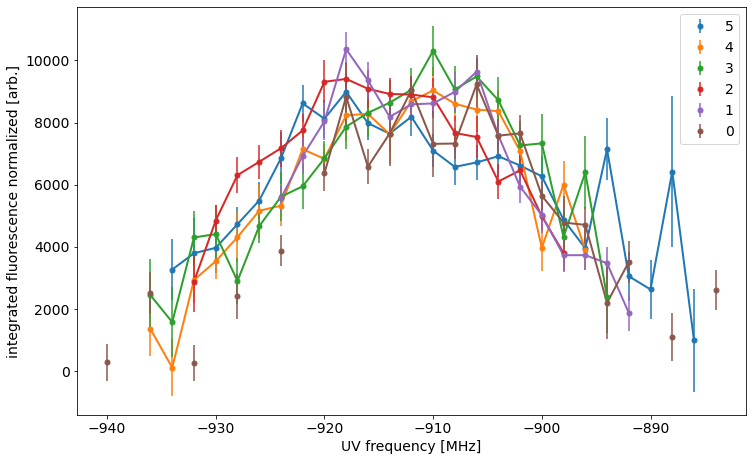

In [93]:
freq_min = -940//4

fig, ax = plt.subplots(figsize = (12,7.5))

for par in sorted(parameters)[::-1]:
    bins, values, err = scan_data_normalized[par]
    m = bins >= freq_min
    bins = bins[m]
    values = values[m]
    err = err[m]
    l = ax.plot(4*bins, values, lw = 2)
    ax.errorbar(4*bins, values, yerr = err, fmt = '.', label = f'{par}', ms = 10,
               color = l[0].get_color())

    ax.legend(fontsize = 14)
    
ax.set_xlabel('UV frequency [MHz]')
ax.set_ylabel('integrated fluorescence normalized [arb.]')

set_fontsize(ax, 14)

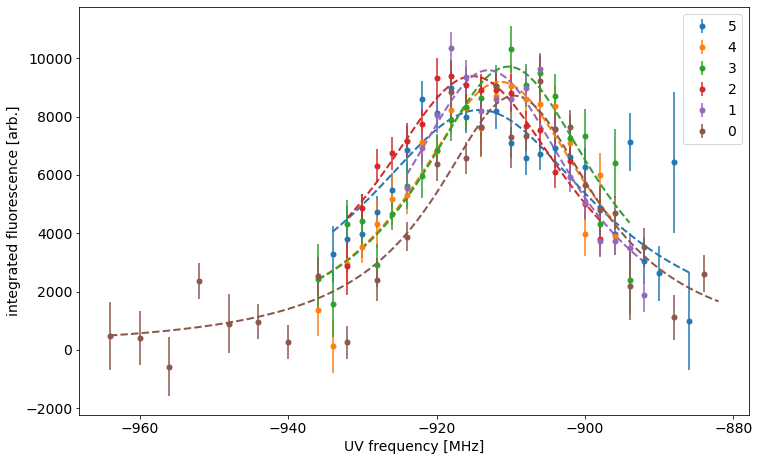

In [83]:
fit_model = lmfit.models.LorentzianModel()
params = fit_model.make_params()


fits = {}

fig, ax = plt.subplots(figsize = (12,7.5))
for idx, par in enumerate(sorted(parameters)[::-1]):
    bins, values, err = scan_data_normalized[par]
    bins = 4*bins
    x = np.linspace(bins.min(), bins.max(), 201)
    
    params.add('amplitude', np.nanmax(values))
    params.add('center', bins[np.nanargmax(values)])
    params.add('sigma', 8)

    mask_notnan = ~np.isnan(values)
    result = fit_model.fit(values[mask_notnan], 
                           params, 
                           weights = 1/err[mask_notnan],
                           x = bins[mask_notnan])
    
    l = ax.plot(x, result.eval(x = x), ls = '--', lw = 2)
    ax.errorbar(bins, values, yerr = err, 
                ms = 10, fmt = '.', ecolor = l[0].get_color(), color = l[0].get_color(),
                label = f'{par}'
               )
    
    fits[par] = result
    
ax.set_xlabel('UV frequency [MHz]')
ax.set_ylabel('integrated fluorescence [arb.]')
ax.legend(fontsize = 14)

set_fontsize(ax, 14)

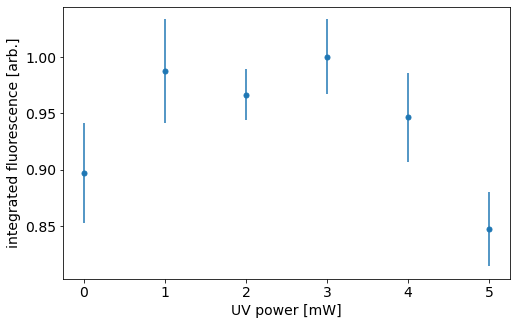

In [86]:
y = np.array([fits[par].params['height'].value for par in parameters])
yerr = np.array([fits[par].params['height'].stderr for par in parameters])/y.max()

y /= y.max()

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(parameters, y, yerr = yerr, fmt = '.', ms = 10)

ax.set_xlabel('UV power [mW]')
ax.set_ylabel('integrated fluorescence [arb.]')
set_fontsize(ax, 14)

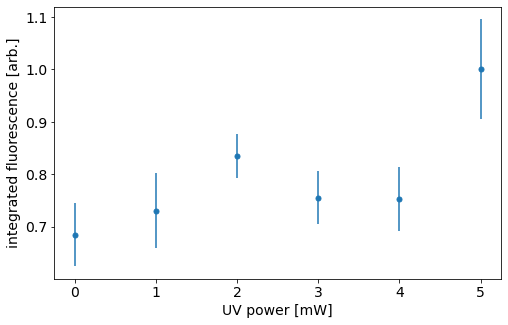

In [88]:
y = np.array([fits[par].params['fwhm'].value for par in parameters])
yerr = np.array([fits[par].params['fwhm'].stderr for par in parameters])/y.max()

y /= y.max()

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(parameters, y, yerr = yerr, fmt = '.', ms = 10)

ax.set_xlabel('UV power [mW]')
ax.set_ylabel('integrated fluorescence [arb.]')
set_fontsize(ax, 14)